In [1]:
import timeit
import re
from pathlib import Path
# from itertools import product, ch

import sys
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


In [2]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

In [3]:
ROOT_SEQUENCE_LENGTH = 1000

TREES_PATH = Path.cwd() / "TRUE_TREES"
time_winners = []
measured_times: list[list[float]] = []



def refresh_sim(tree_file, indel_rate):
    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=indel_rate[0], rate_del=indel_rate[1],
                                deletion_extra_edge_length=50,
                                switch_factor=50,
                                seed=81)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)

    return sim

branches_dfs = []

NUMBER_OF_WINS = 4
stop_flag = NUMBER_OF_WINS

rates = [i*0.01 for i in range(1,10)]
rates = list(zip(rates, rates[::-1]))

for RATE_MULTIPLIER in range(1,21):#[0.5, 1,2,4,8,16]:
    print(RATE_MULTIPLIER)
    for indel_rate in rates:
        factor_compare = {"branch_scale": [], 
                    "blocklist_time": [], "blocktree_time": [],
                    "true": [], "factor": [],
                    "insertion_rate": [indel_rate[0]], "deletion_rate": [indel_rate[1]]
                    }
        scaled_tree_path = scale_tree("scaled_trees/test_tree.txt", RATE_MULTIPLIER)
        print(indel_rate)
        sim = refresh_sim(scaled_tree_path, indel_rate)
        factor_compare["true"].append(len(sim.sim_nodes[1].list_of_events))
        factor_compare["factor"].append(sim.sim_nodes[1].hybrid_factor)

        blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=5)
        blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=5)
        factor_compare["blocklist_time"].append(blocklist_time)
        factor_compare["blocktree_time"].append(blocktree_time)
        factor_compare["branch_scale"].append(RATE_MULTIPLIER)
        comparison_df = pd.DataFrame(factor_compare)
        branches_dfs.append(comparison_df)
    # if blocktree_time < blocklist_time:
    #     stop_flag -= 1
    # else:
    #     stop_flag = NUMBER_OF_WINS
    # if stop_flag == 0:
    #     break
    # comparison_df.plot.scatter(x="factor",y="true")

1
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
2
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
3
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
4
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
5
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
6
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
7
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
8
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 0.06)
(0.05, 0.05)
(0.06, 0.04)
(0.07, 0.03)
(0.08, 0.02)
(0.09, 0.01)
9
(0.01, 0.09)
(0.02, 0.08)
(0.03, 0.07)
(0.04, 

AttributeError: 'NoneType' object has no attribute 'length_under_including'

In [4]:
branches_df = pd.concat(branches_dfs)
# branches_df[branches_df["blocklist_time"] > branches_df["blocktree_time"]]
branches_df.reset_index

<bound method DataFrame.reset_index of     branch_scale  blocklist_time  blocktree_time  true  factor  \
0              1        0.176562        0.187767     6    10.0   
0              1        0.164298        0.192142     6    10.0   
0              1        0.185580        0.212495     6    10.0   
0              1        0.190023        0.224014     7    10.0   
0              1        0.197718        0.231450     7    10.0   
..           ...             ...             ...   ...     ...   
0             14        0.703847        1.317847   149   140.0   
0             14        1.135774        1.993691   150   140.0   
0             14        3.539698        4.166714   161   140.0   
0             14       11.963859        8.374084   166   140.0   
0             14       80.813678       24.648822   174   140.0   

    insertion_rate  deletion_rate  
0             0.01           0.09  
0             0.02           0.08  
0             0.03           0.07  
0             0.04      

In [9]:
branches_df.reset_index(drop=True).to_csv("comparison.csv")

In [5]:
rates = [i*0.01 for i in range(1,10)]
rates = list(zip(rates, rates[::-1]))
rates

[(0.01, 0.09),
 (0.02, 0.08),
 (0.03, 0.07),
 (0.04, 0.06),
 (0.05, 0.05),
 (0.06, 0.04),
 (0.07, 0.03),
 (0.08, 0.02),
 (0.09, 0.01)]

In [2]:
branches_df = pd.read_csv("comparison.csv", index_col=0)

In [5]:
# branches_df = branches_df.reset_index(drop=True)
branches_df

,branch_scale,blocklist_time,blocktree_time,true,factor,insertion_rate,deletion_rate
0,1,0.176562,0.187767,6,10.0,0.01,0.09
0,1,0.164298,0.192142,6,10.0,0.02,0.08
0,1,0.185580,0.212495,6,10.0,0.03,0.07
0,1,0.190023,0.224014,7,10.0,0.04,0.06
0,1,0.197718,0.231450,7,10.0,0.05,0.05
...,...,...,...,...,...,...,...
0,14,0.703847,1.317847,149,140.0,0.05,0.05
0,14,1.135774,1.993691,150,140.0,0.06,0.04
0,14,3.539698,4.166714,161,140.0,0.07,0.03
0,14,11.963859,8.374084,166,140.0,0.08,0.02


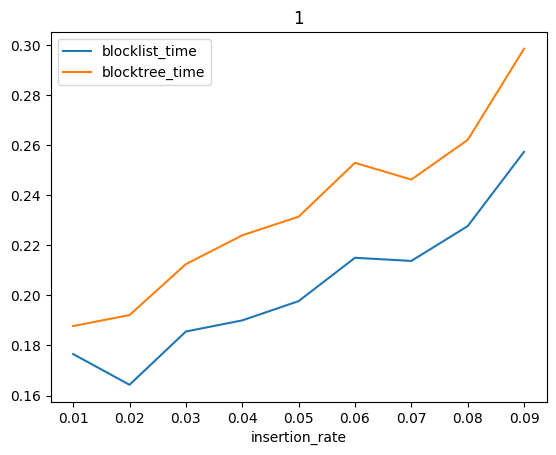

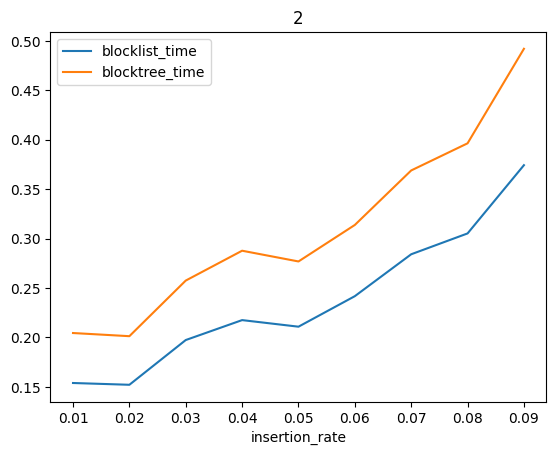

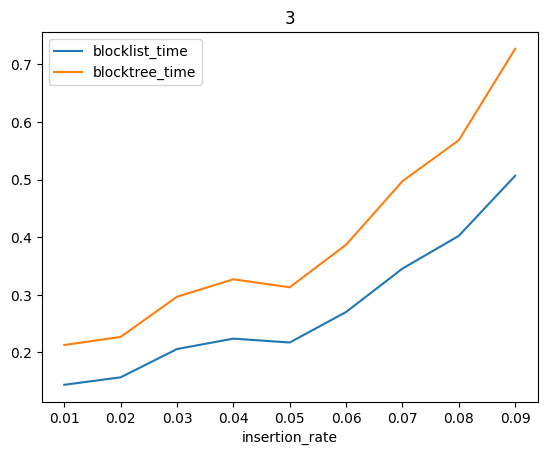

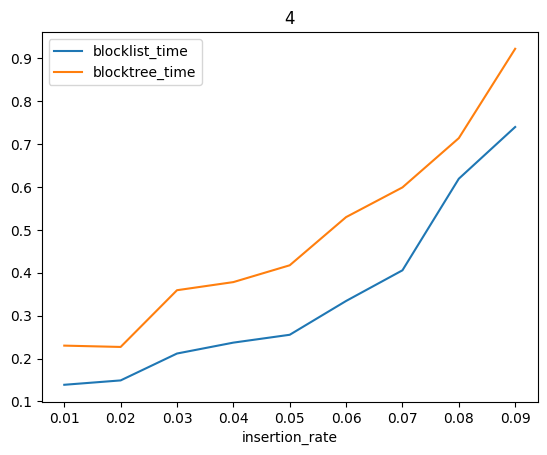

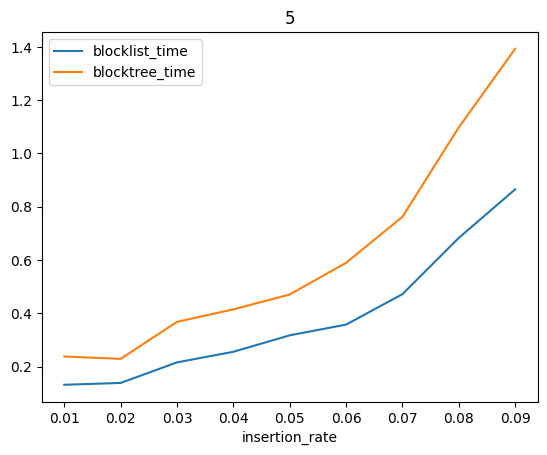

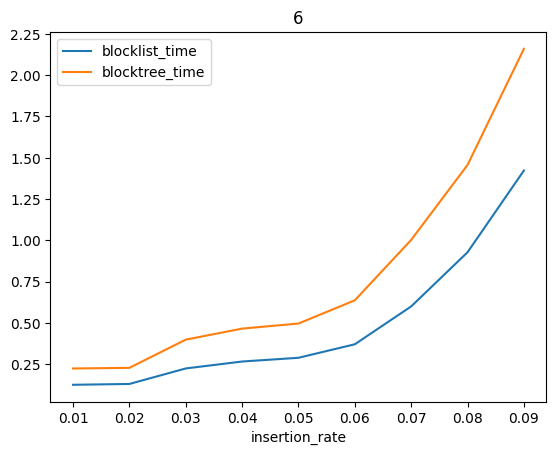

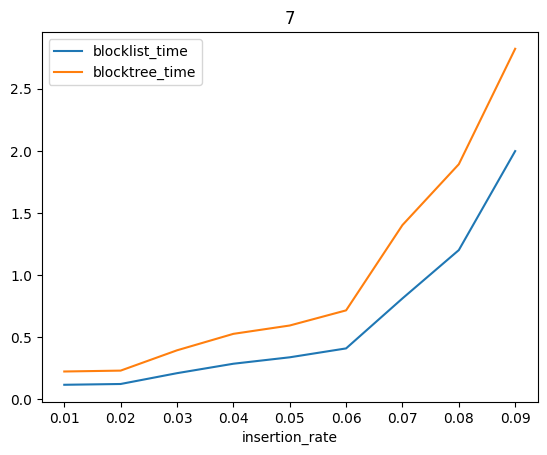

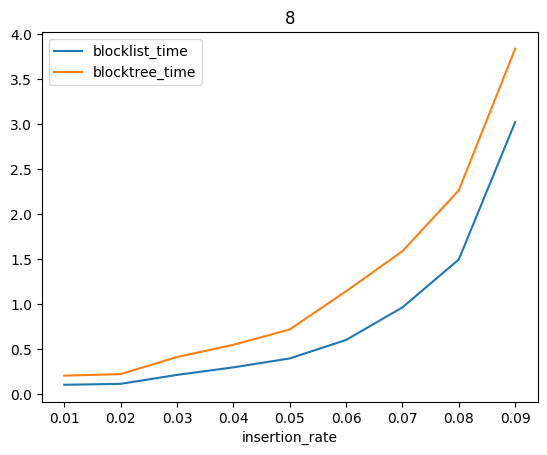

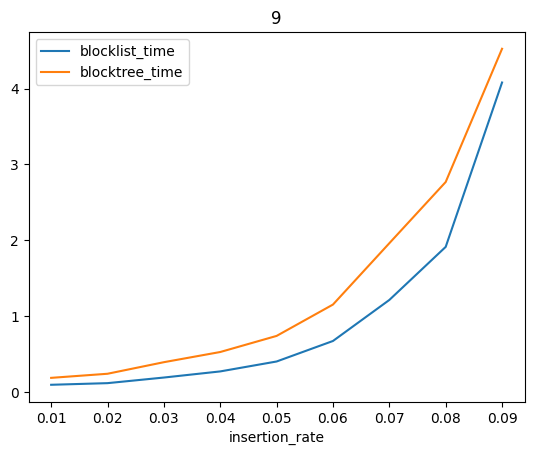

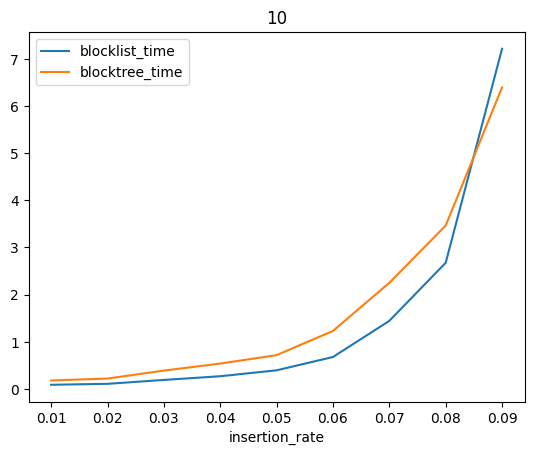

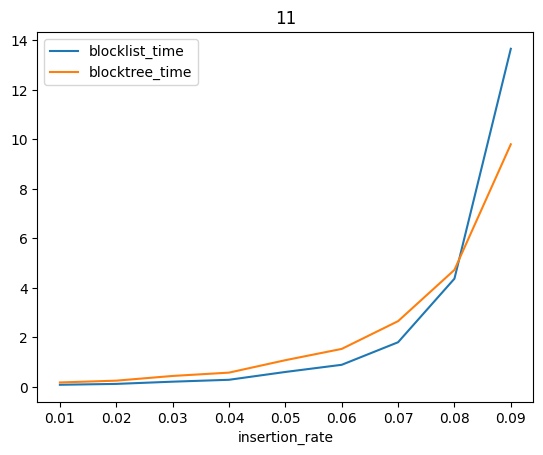

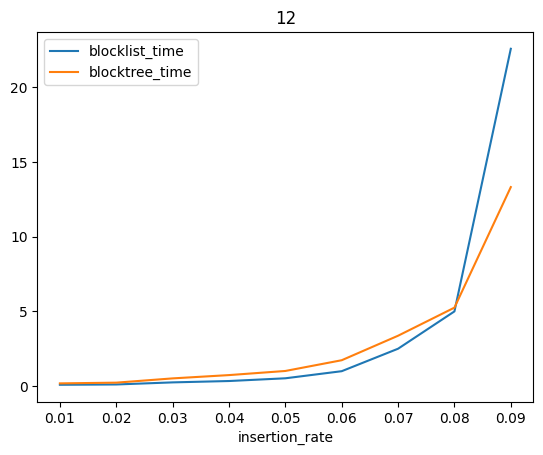

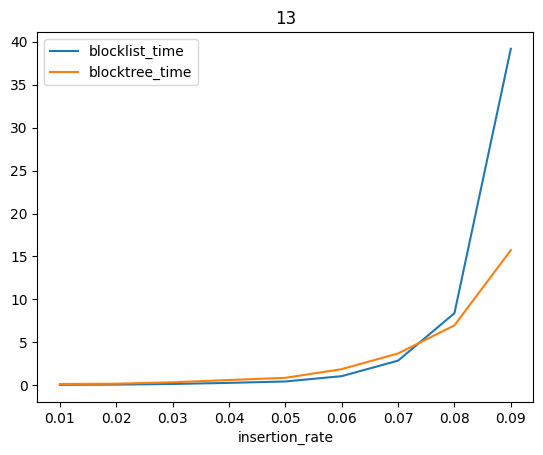

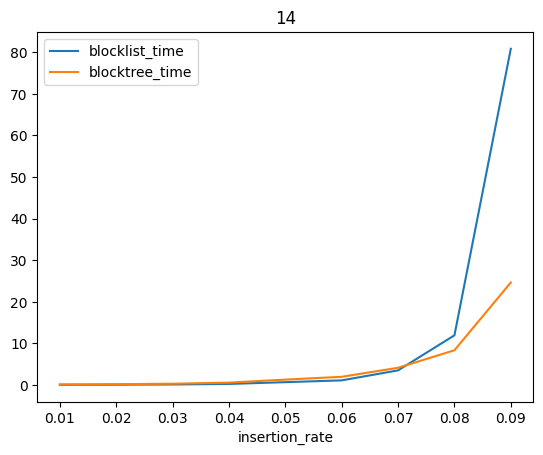

In [ ]:
for group in branches_df.groupby("branch_scale"):
    group[1][["blocklist_time", "blocktree_time", "insertion_rate"]].plot(x ="insertion_rate",
                                                                          title=f"Branches multiplied by {group[0]}")


In [37]:
comparison_df.corr()

,branch_scale,blocklist_time,blocktree_time,true,factor
branch_scale,NaN,NaN,NaN,NaN,NaN
blocklist_time,NaN,NaN,NaN,NaN,NaN
blocktree_time,NaN,NaN,NaN,NaN,NaN
true,NaN,NaN,NaN,NaN,NaN
factor,NaN,NaN,NaN,NaN,NaN


In [18]:
comparison_df["dist"] = (comparison_df.true - comparison_df.factor)**2

In [19]:
comparison_df.loc[comparison_df["dist"].argmax()]

true      17.000000
factor     9.581449
dist      55.034896
Name: 3, dtype: float64

In [6]:
a = -2.0

zipf_sum = sum([x**a for x in range(1,51)])
avg = sum([x*(x**a/zipf_sum) for x in range(1,51)])
avg

2.768515608139384